In [1]:
%tensorflow_version 1.x
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import keras
from keras.models import load_model
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

import re
numbers = re.compile(r'(\d+)')


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
    
def resizeX(filename, size = (224,224)):
    im = Image.open(filename)
    im_resized = im.resize(size)
    return (im_resized)

def resizeY(filename, size = (224,224)):
    im = Image.open(filename)
    im_resized = im.resize(size).convert('1')
    return (im_resized)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.common.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename, x_train, y_train, x_val, y_val, learningRate = 0.003):
    dropout_val=0.50
    if K.common.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = load_model('/content/drive/My Drive/models/pre_100_epoch.h5' ,custom_objects = {'iou' : iou, 'dice_coe' : dice_coe, 'precision' : precision, 'recall' : recall, 'accuracy' : accuracy, 'jaccard_distance' : jaccard_distance})
    # model = load_model('/content/drive/My Drive/models/pre_100_epoch.h5')
    # model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = learningRate), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 3,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

def enhance(img, filename):
    model.load_weights('/content/drive/My Drive/models/' + filename)
    sub = (model.predict(img.reshape(1,224,224,3))).flatten()

    # for i in range(len(sub)):
    #     if sub[i] <= 0.165:
    #         sub[i] = 0
    #     elif sub[i] <= 0.97:
    #         sub[i] = 1
    #     else:
    #         sub[i] = 2
    return sub

In [3]:
filelist_trainx = sorted(glob.glob('/content/drive/My Drive/input/after_train_x_notWater/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/drive/My Drive/input/after_train_y/*.jpg'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testX = sorted(glob.glob('/content/drive/My Drive/input/testX_notWater/*.jpg'), key=numericalSort)
x_test = np.array([np.array(Image.open(fname)) for fname in filelist_testX])

filelist_testY = sorted(glob.glob('/content/drive/My Drive/input/testY/*.jpg'), key=numericalSort)
y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testY])

print(len(filelist_trainx))
print(len(filelist_trainy))

X_train_ph2_resized = []
Y_train_ph2_resized = []
X_test_ph2_resized = []
Y_test_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_train_ph2_resized.append(resizeX(filelist_trainx[i]))
    Y_train_ph2_resized.append(resizeY(filelist_trainy[i]))

for i in range(len(filelist_testX)):
    X_test_ph2_resized.append(resizeX(filelist_testX[i]))
    Y_test_ph2_resized.append(resizeY(filelist_testY[i]))

del(X_train)
del(Y_train)
del(x_test)
del(y_test)

x_train = np.array([np.array(img) for img in X_train_ph2_resized])
y_train = np.array([np.array(img) for img in Y_train_ph2_resized])
x_test = np.array([np.array(img) for img in X_test_ph2_resized])
y_test = np.array([np.array(img) for img in Y_test_ph2_resized])

# x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

82
82
Length of the Training Set   : 393
Length of the Test Set       : 20
Length of the Validation Set : 99


In [4]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

# iou, dice_coe, precision, recall, accuracy
# callback_list =[ keras.callbacks.ModelCheckpoint( filepath = '/content/drive/My Drive/models/pre_100_epoch.h5',monitor = 'val_loss',save_best_only=True )]


model, hist = UNET_224(100, '/content/drive/My Drive/models/after_notWater_100_epoch.h5', x_train, y_train, x_val, y_val, 0.0003)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 224, 224, 32) 128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 224, 224, 32) 0           batch_normalization_45[0][0]     
________

In [5]:
model.load_weights('/content/drive/My Drive/models/after_notWater_100_epoch.h5')

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

393/393 [==============================] - 3s 9ms/step
________________________
IOU:       |   99.27  |
Dice Coef: |   94.83  |
Precision: |   95.86  |
Recall:    |   95.97  |
Accuracy:  |   99.39  |
Loss:      |   0.73  |
________________________

-------------On Test  Set--------------------------

20/20 [==============================] - 0s 21ms/step
________________________
IOU:       |   98.79  |
Dice Coef: |   92.64  |
Precision: |   93.68  |
Recall:    |   94.13  |
Accuracy:  |   99.08  |
Loss:      |   1.21  |
________________________

-------------On validation Set---------------------

99/99 [==============================] - 1s 10ms/step
________________________
IOU:       |   99.24  |
Dice Coef: |   94.21  |
Precision: |   95.84  |
Recall:    |   95.05  |
Accuracy:  |   99.38  |
Loss:      |   0.76  |
________________________


In [6]:
for i in range(len(x_train)):
  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.title('Origin Image')
  plt.imshow(x_train[i])
  plt.subplot(1,3,2)
  plt.title('Ground Truth')
  plt.imshow(y_train[i], plt.cm.binary_r)
  plt.subplot(1,3,3)
  plt.title('Predicted')
  plt.imshow(enhance(x_train[i], 'after_notWater_100_epoch.h5').reshape(224,224), plt.cm.binary_r)
  # plt.subplot(3,2,5)
  # plt.title('Ground_Truth_out')
  # plt.imshow(Y_train_out[i],plt.cm.binary_r)
  # plt.subplot(3,2,6)
  # plt.title('Predicted_out')
  # plt.imshow(enhance_out(X_train[i]).reshape(224,224),plt.cm.binary_r)
  plt.savefig('/content/drive/My Drive/results/total/after_notWater_train/' + str(i) + '.jpg')

Output hidden; open in https://colab.research.google.com to view.

0 번째 사진의 정확도 
iou :  0.8900210822206606
dice :  0.94182156133829
acc :  0.9875239158163265

1 번째 사진의 정확도 
iou :  0.9464205312922107
dice :  0.9724791859389454
acc :  0.9952566964285714

2 번째 사진의 정확도 
iou :  0.9110992339212542
dice :  0.9534905396588685
acc :  0.9900550063775511

3 번째 사진의 정확도 
iou :  0.9118509573917544
dice :  0.9539016689219666
acc :  0.9898158482142857

4 번째 사진의 정확도 
iou :  0.890284757118928
dice :  0.9419669226225635
acc :  0.9843351403061225

5 번째 사진의 정확도 
iou :  0.9443614637789395
dice :  0.9713883377072265
acc :  0.9910913584183674

6 번째 사진의 정확도 
iou :  0.9120353330879647
dice :  0.954011929959592
acc :  0.9952367665816326

7 번째 사진의 정확도 
iou :  0.9286828616001783
dice :  0.9630314232902033
acc :  0.9936224489795918

8 번째 사진의 정확도 
iou :  0.9406124342715744
dice :  0.9694072657743786
acc :  0.9961734693877551

9 번째 사진의 정확도 
iou :  0.9576228686058175
dice :  0.9783583045204252
acc :  0.9966318558673469

10 번째 사진의 정확도 
iou :  0.9099756690997567
dice :  0.9528812480101

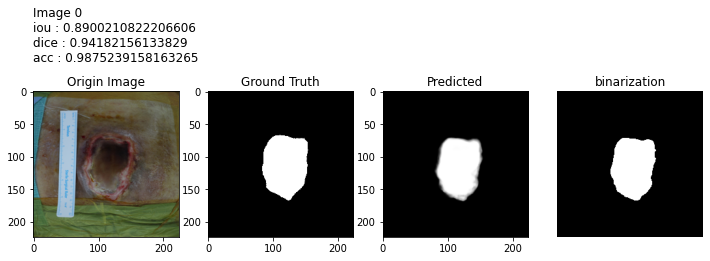

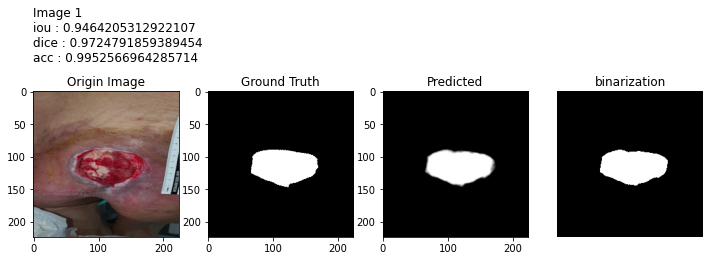

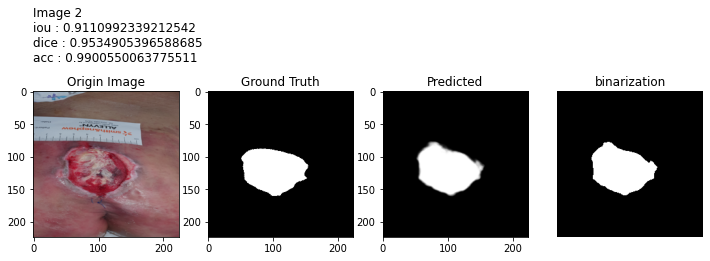

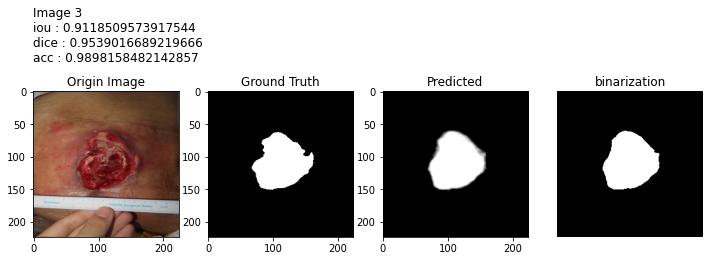

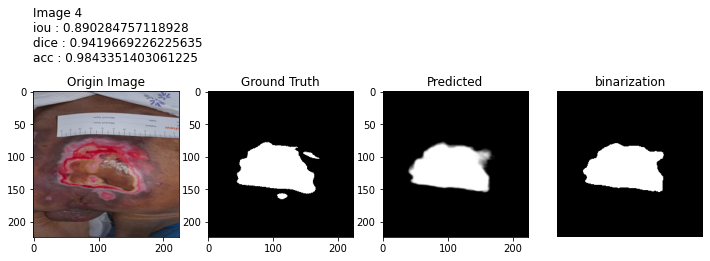

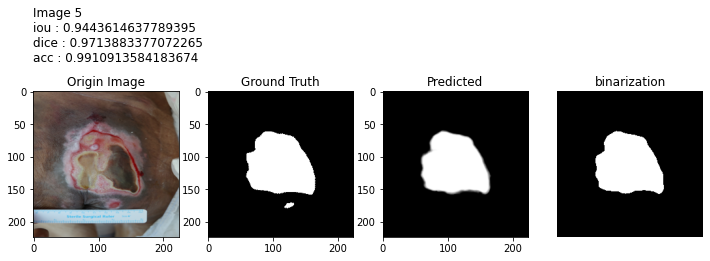

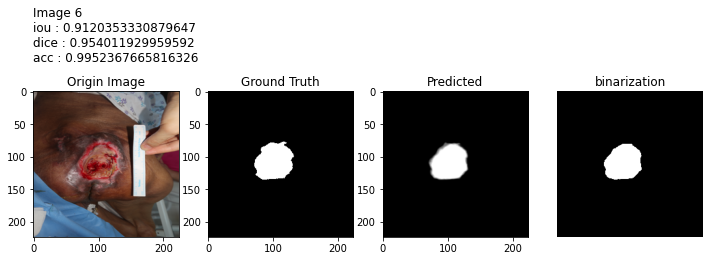

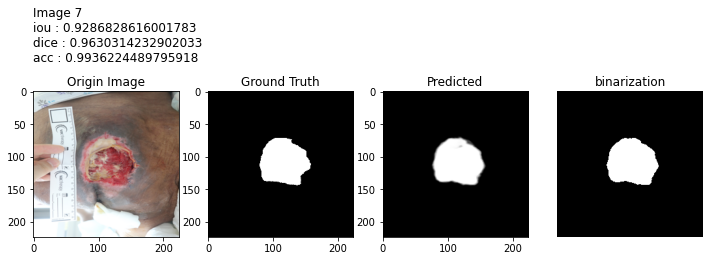

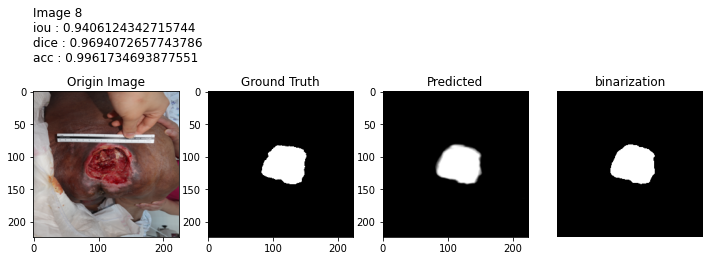

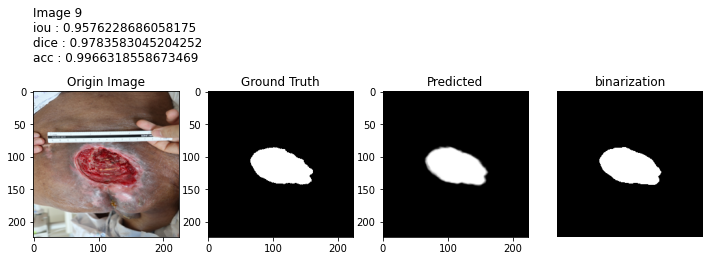

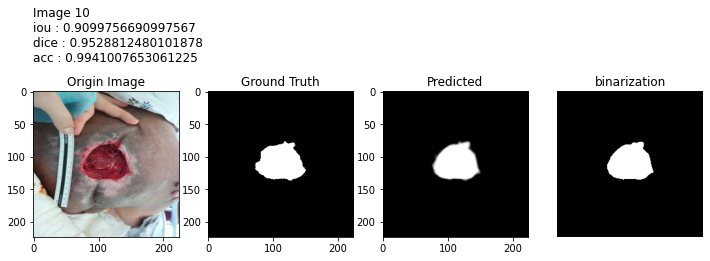

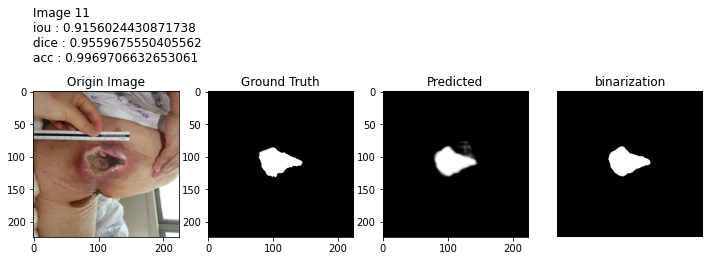

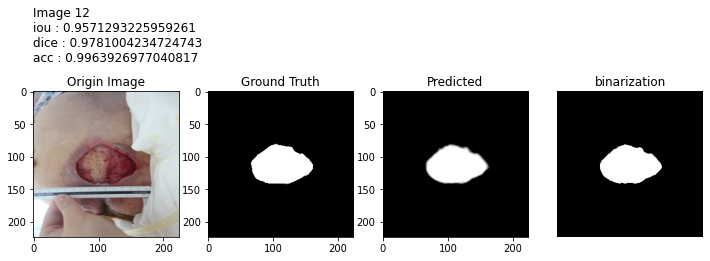

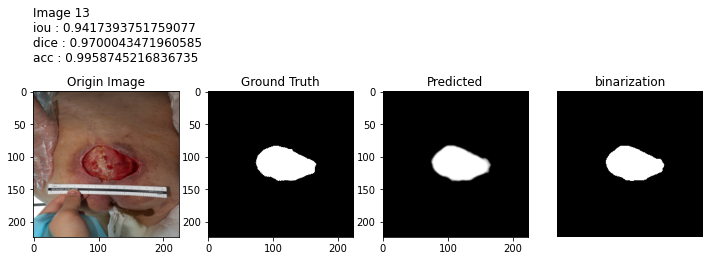

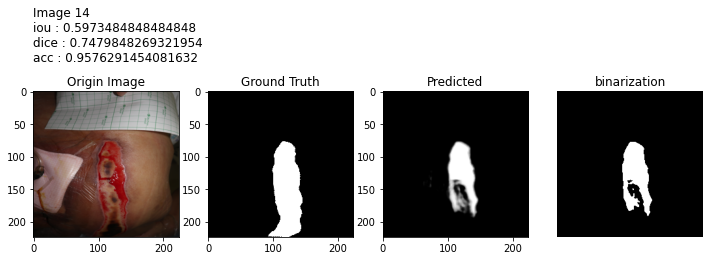

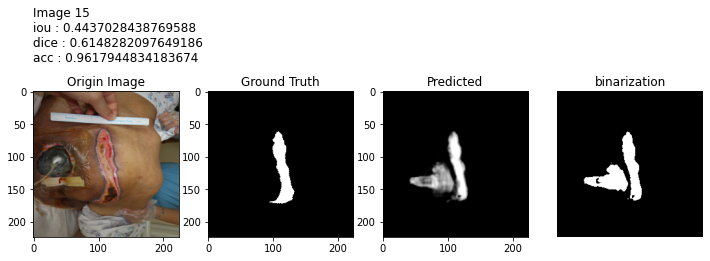

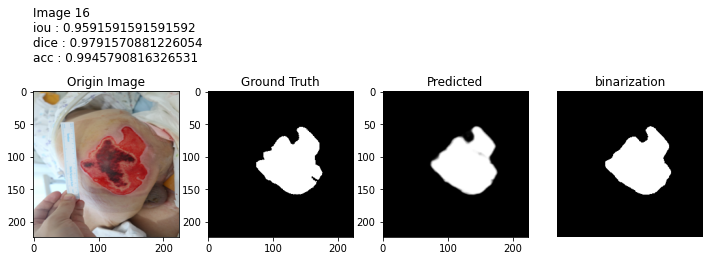

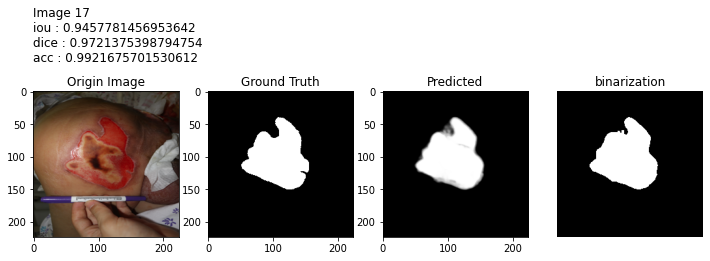

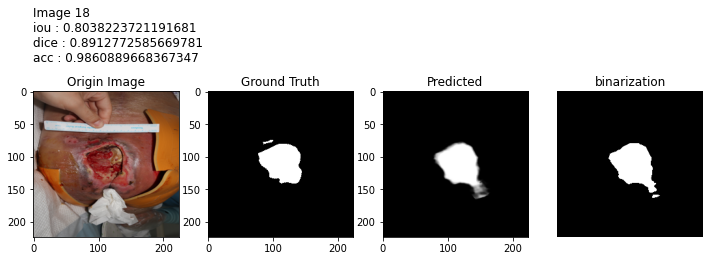

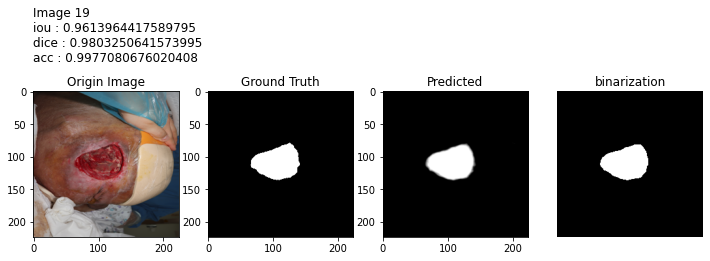

In [7]:
sum_iou = 0
sum_dice = 0
sum_acc = 0

for i in range(len(x_test)):
  pdata = (model.predict(x_test[i].reshape(1,224,224,3))).reshape(1,224,224,1)
  # print(pdata.shape)
  # ensemble = np.zeros((1,224,224,1))
  # print(pdata.shape)
  # for j in range(224) :
  #       for k in range(224) :
  #           ensemble[i][j][[k]0] = pdata[j][k][0]
  ensemble = pdata
  ensemble = ensemble * 255
  ensemble = ensemble.squeeze(axis=0)
  # print(ensemble.shape)
  ensemble = ensemble.astype(np.uint8)
  ret3, th3 = cv2.threshold(ensemble, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


  th3 = th3/255
  # print(th3.shape)
  # print(y_test[i].shape)
  A = 1
  cnt = 1
  B = 1
  C = 0
  top = 0
  bottom = 0

  for j in range(224) :
      for k in range(224) : 
          A += y_test[i][j][k]
          B += th3[j][k]     
          if y_test[i][j][k] == th3[j][k] : # 00, 11 인 경우
              cnt += th3[j][k]
              top += th3[j][k]
              bottom += th3[j][k]
              C+=1
          else : # 01 10 인 경우
              bottom += 1
  
  dice = cnt*2 / (A+B) 
  iou = top / bottom
  acc = C / (224*224)
  
  sum_acc += acc
  sum_iou +=iou
  sum_dice += dice
  print(i , '번째 사진의 정확도 ')
  print('iou : ' , iou)
  print('dice : ' , dice)
  print('acc : ', acc)
  print()
  inputStr = 'Image ' + str(i) + '\n' + 'iou : ' + str(iou) + '\ndice : ' + str(dice) + '\nacc : ' + str(acc) + '\n'
  # print(inputStr)


  plt.figure(figsize=(12,6))
  ax1 = plt.subplot(2,4,5)
  plt.title('Origin Image')
  plt.imshow(x_test[i])
  plt.subplot(2,4,6)
  plt.title('Ground Truth')
  plt.imshow(y_test[i], plt.cm.binary_r)
  plt.subplot(2,4,7)
  plt.title('Predicted')
  plt.imshow(enhance(x_test[i], 'after_notWater_100_epoch.h5').reshape(224,224), plt.cm.binary_r)
  plt.subplot(2,4,8)
  plt.imshow(th3.squeeze(), plt.cm.binary_r)
  plt.title('binarization')
  plt.axis('off')
  ax1.text(0, 1.1, s = inputStr, size=12,transform=ax1.transAxes)
  plt.savefig('/content/drive/My Drive/results/total/after_notWater_test/' + str(i) + '.jpg')

print('acc : ',sum_acc/20)
print('iou : ',sum_iou/20)
print('dice : ',sum_dice/20)